# Lec 1

## Objective

General setup:

- Install dependencies
- Import TensorFlow Layers
- Config GPU
- Create Data folder

## 1.1 Install and import dependencies

First create a virtual environment for the project

In [1]:
#%python3 -m venv venv

# Activate the virtual environment
#%source venv/bin/activate

Then install the dependencies

In [2]:
#%pip install tensorflow 

In [3]:
#%pip install opencv-python

In [4]:
#%pip install matplotlib

Now import some necessary dependencies

In [5]:
import cv2 # OpenCV
import os  # For file operations
import random
import numpy as np
from matplotlib import pyplot as plt # For plotting graphs

In [6]:
# Import TensorFlow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D,  Dense, MaxPool2D, Flatten, Input
import tensorflow as tf


2024-10-22 21:56:06.951157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 21:56:06.952323: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 21:56:06.958487: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 21:56:06.977745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 21:56:07.009614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

- Conv2D for Convolutional Neural Networks
- Dense for Fully Connected Neural Networks
- MaxPooling2D to pull our layers together and effectively reduce the number of parameters and computations in the network
- Flatten take output from previous layer and flatten it to a vector to be fed into the next layer

## 1.2 Setup GPU Limit for TensorFlow

In [7]:
# Avoid Memory Error when TensorFlow use two much VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
gpus # Show all GPUs available in machine

[]

## 1.3 Create Data Folder

When we perform facial verification, we actually want to compare two images and determine if they are of the same person. This is a one-shot learning problem. We will learn a function that maps our input data (images) to a feature space such that the distance between the features can be used to determine if the images are of the same person.

We will create three data folders:

- anchors
- positive
- negative

The anchor image is the image of the person we want to verify.(Input)
The positive or negative are verification images. The positive is an image of the same person as the anchor image but taken under different conditions. The negative image is an image of a different person.

When we pass in a anchor image, if:

- it matches the positive image, the output should be 1 (same)
- it matches the negative image, the output should be 0 (different)

We want our model to distinguish between outselves and others person. The process will be as follows:


Fix spelling later :)))

![AnchorAndPositive](resources/images/AnchorAndPositive.jpg)

![AnchorAndPNegative](resources/images/AnchorAndNegative.jpg)

**Labeled Face Wild Dataset (LFW)** is a dataset for studying Face Verification. It contains 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. We use this date set as negative images to train the model distinguishing outselves from others. We will explore this dataset in the lecture 2.

In [9]:
#Set up Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Why need 'join' ? -> Because it will automatically add the correct path separator for the OS like '/' or '\'

In [10]:
POS_PATH

'data/positive'

In [11]:
# Create those directories in machine
os.makedirs(POS_PATH, exist_ok=True) # DO not overwrite if already exists
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# Lec 2

## Objective

- Unpack Labeled Faced in the Wild (LFW) dataset
- Collect Anchr images
- Collect Positive images

## 2.1 Unpack LFW dataset for Negative Images

Found in this link: https://vis-www.cs.umass.edu/lfw/

Download -> All images as gzipped tar file -> lfw.tgz. Then move to the project workspace and extract the file using:

```bash
tar -xvzf lfw.tgz
```


![datasetView1](resources/images/datasetView1.png)


After extract, we see the structure of the dataset contains many folders, each folder is a person's name and contains some image(s) of that person inside the folder. We now want to collect all these images in the wholde dataset and put them into our `data/negative` folder. (Only need to take the images, not the folders outside).

**Uncomment the above code when run the notebook for the first time**

In [12]:
# # Define the path to the extracted LFW dataset
# LFW_PATH = os.path.join('lfw')
# #

# #  Collect all images from the LFW dataset and move them to the 'data/negative' folder
# for dirpath, dirnames, filenames in os.walk(LFW_PATH):
#     for filename in filenames:
#         if filename.endswith('.jpg'):
#             src_path = os.path.join(dirpath, filename)
#             dst_path = os.path.join(NEG_PATH, filename)
#             os.replace(src_path, dst_path)

It should look something like this in out `data/negative` folder:

![datasetView2](resources/images/datasetView2.png)

## 2.2 Collect Positive and Anchor Images

We will collect these images **from our webcam** using OpenCV. The images from LFW have size 250x250, so we will resize the images from our webcam to 250x250 as well.

**First, test the webcam:**


In [13]:
# Defined the Camera ID to use
CAM_ID = 3 # Establishing the connection with the IR camera


- CAM_ID = 0 for laptop normal webcam
- CAM_ID = 2 for laptop IR webcam
- CAM_ID = 4 for external webcam


***Depend on each devices, these number can be different. Try out all number start from 0 and see which one is the correct one on your device.***


Set up camera:

**IR webcam:**

What is IR webcam? https://fptshop.com.vn/tin-tuc/danh-gia/ir-camera-la-gi-153147


**External webcam**

Since the resolution of the laptop webcam is not good, we will use an external webcam like from a mobile phone. To connect the webcam to the laptop:

1. Download the DroidCam app on your phone, also the DroidCam client on your laptop: https://www.dev47apps.com/
2. Set up as the instruction on the website. With Linux:

```bash
wget -O droidcam_latest.zip https://files.dev47apps.net/linux/droidcam_2.1.3.zip
unzip droidcam_latest.zip -d droidcam
cd droidcam && sudo ./install-client
sudo apt install libappindicator3-1

# Fix missing video device
sudo apt install linux-headers-`uname -r` gcc make
sudo ./install-video
```
3. Open both DroidCam on phone and DroidCam client on laptop, connect the phone to the laptop via USB or Wifi.


Now try to use OpenCV to capture the image from the webcam:


In [14]:
cap = cv2.VideoCapture(CAM_ID)  # Connect to the camera
while cap.isOpened():  # Loop through every single frame
    ret, frame = cap.read()  # Read the frame
    if not ret:
        break

    cv2.imshow('Image Collection', frame)  # Display the frame to screen

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Wait for 1ms and check if 'q' is pressed
        break

cap.release() 
cv2.destroyAllWindows()  # Close the window

**Press `q` to exit**


After that, we show to last frame/image captured when press `q`:

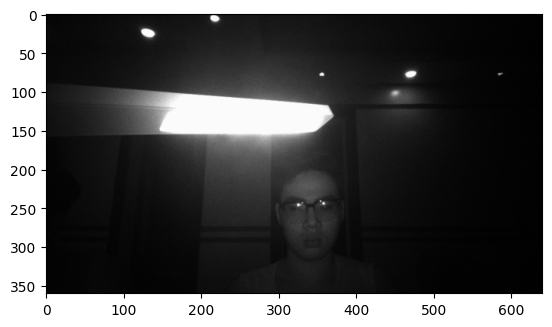

In [15]:
plt.imshow(frame) # Display the image

Note that by default, OpenCV reads images in **BGR** (Blue, Green, Red) format so the image will look a bit weird.

In [16]:
frame.shape # Check the shape of the image

(360, 640, 3)

In [17]:
frame

array([[[4, 4, 4],
        [6, 6, 6],
        [5, 5, 5],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[5, 5, 5],
        [4, 4, 4],
        [5, 5, 5],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [3, 3, 3]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [4, 4, 4],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [2, 2, 2],
        [0, 0, 0],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [4, 4, 4],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]]], dtype=uint8)

When using normal webcam, the result look something like this:

```plaintext
array([[[181, 163, 164],
        [186, 168, 168],
        [186, 164, 168],
        ...,
        [104, 107, 104],
        [104, 106, 106],
        [105, 107, 107]],

       [[183, 167, 167],
        [183, 167, 167],
        [180, 162, 163],
```
Each [181, 163, 164] is a pixel value of the image. The first value is the Blue channel, the second is the Green channel, and the third is the Red channel. The value of each channel is from 0 to 255.

Whereas when using IR webcam, the result look something like this:

```plaintext
array([[[16, 16, 16],
        [15, 15, 15],
        [23, 23, 23],
        ...,
        [ 6,  6,  6],
        [ 7,  7,  7],
        [ 6,  6,  6]],
```

Each picxel is just a single value, which is the gray intensity of the pixel. The value is from 0 to 255. However they are write duplicated 3 times to match the RGB format, so when use frame.shape, it will return (480, 640, 3) instead of (480, 640, 1).

However, this is not 250x250 yet, we will resize the image to 250x250.




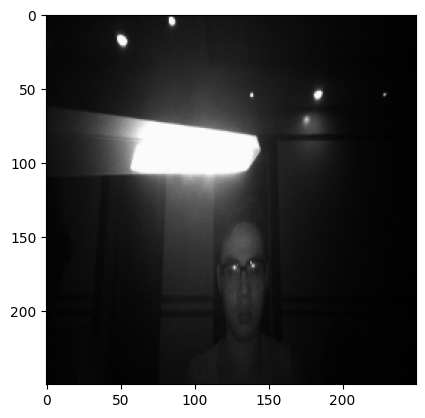

In [18]:
#Resize the image to 250x250
resized_frame = cv2.resize(frame, (250, 250))
plt.imshow(resized_frame)

### Face Detection

Just resize the image to 250x250 will make the image look weird, so instead, we should crop the image to 250x250, by not by arbitrary, but by the face of the person in the image. We will use the Haar Cascade Classifier to detect the face in the image and crop the image to the face.

In [19]:
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert the frame to grayscale as the face detector expects gray images
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

# If faces are detected, crop the first face found
if len(faces) > 0:
    (x, y, w, h) = faces[0]  # Get the coordinates of the first face
    cropped_face = frame[y:y+h, x:x+w]  # Crop the face from the frame

    # Resize the cropped face to 250x250
    resized_face = cv2.resize(cropped_face, (250, 250))

    # Display the resized face
    plt.imshow(cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("No faces detected")

No faces detected


### Collect images to anchor and positive folders

Now we will collect the images to the anchor and positive folders. Create a capture frame, then when press `a`, detect the face in current frame then crop that face to 250x250 image then save to the anchor folder. When press `p`, the image will be saved to the positive folder. notify to the user when the image is saved successfully or not

In [20]:
import uuid # For generating unique image file names

# Function to save the captured image to the specified folder
def save_image(image, folder_path, img_name):
    img_path = os.path.join(folder_path, img_name)
    cv2.imwrite(img_path, image)

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face Collection', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('a'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/anchor'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
            save_image(resized_face, ANC_PATH, str(uuid.uuid1())+ ".jpg")
            print("Image saved as anchor")
        else:
            # Show a dialog if no faces are detected
            print("No faces detected")


    elif key == ord('p'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
            save_image(resized_face, POS_PATH, str(uuid.uuid1())+ ".jpg")
            print("Image saved as positive")
        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected")

    elif key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

Tim hieu them ve tuat toanFace Detection nay ????

# Lec 3

## Objective

- Preprocess the images
- Create positive and negative samples
- Load data into TensorFlow Dataloader

## 3.1 Get Image Directories

In [21]:
# Load directories to TensorFlow datasets
# Take 50 images from each folder
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(50) # This create a pipeline of all images in the folder
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(50)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(50)

We take an example path from `anchor` folder for testing purpose in Preprocess step.

In [22]:
# Take an example path from the anchor dataset
example_anchor_path = next(iter(anchor))

# Print the example path
print(example_anchor_path.numpy())

b'data/anchor/a1655773-8dc8-11ef-aed0-6c2408e04a02.jpg'


## 3.2 Preprocess the images

In [23]:
def preprocess(file_path):
    # Read the image from the file path
    byte_image = tf.io.read_file(file_path) # Read the image as bytes
    image = tf.image.decode_jpeg(byte_image) # Decode the image from bytes to tensor

    # Preprocess the image
    image = tf.image.resize(image, (100,100)) # Resize the image to 100x100
    image = image / 255.0 # Scale image pixel values range [0,1]
    return image

The correct dimension to resize will base on the model we use. For example:

- VGGFace: 224x224
- Facenet: 160x160
-....

Thu tim them cac model khac va kich thuoc anh phu hop


Test the preprocess function with the example path from the previous step.

Value range before preprocessing: 0 - 251


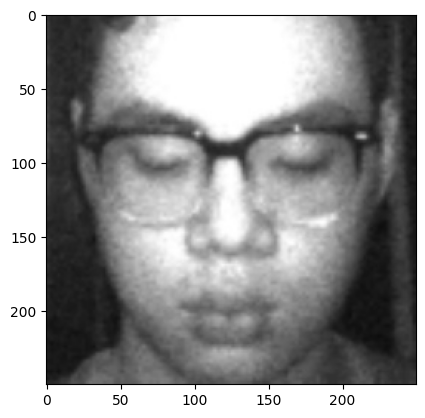

Value range before preprocessing: 0.05269608 - 1.0


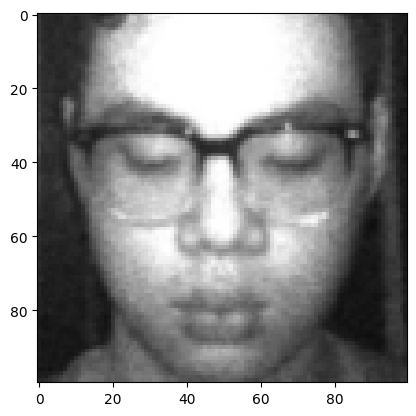

In [24]:
# Images before preprocessing
plt.imshow(cv2.imread(example_anchor_path.numpy().decode()))
# Value range
print("Value range before preprocessing:", frame.min(), "-", frame.max())
plt.show()


# Images after preprocessing
preprocessed_image_test = preprocess(example_anchor_path)
print("Value range before preprocessing:", preprocessed_image_test.numpy().min(), "-", preprocessed_image_test.numpy().max())
plt.imshow(preprocessed_image_test)
plt.show()

## 3.3 Create labled Dataset

We want to create a dataset that labels as follow:

- Given two input: Anchor + Positive => 1
- Given two input: Anchor + Negative => 0

In [25]:
# Create labels
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))) #each label has the same size as the anchor
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

# Zip the datasets with their labels
positives = tf.data.Dataset.zip((anchor, positive, positive_labels))
negatives = tf.data.Dataset.zip((anchor, negative, negative_labels))

# Concatenate the datasets
data = positives.concatenate(negatives)

In [26]:
# View the first 5 examples
# Print the dataset to verify
for element in data.take(5):
    print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data/anchor/4ab09416-9037-11ef-bcfa-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/positive/a76e3f08-8dc8-11ef-b02f-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/anchor/9d121f40-8dc8-11ef-a545-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/positive/a4a1fe67-8dc8-11ef-b468-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/anchor/9f33dd26-8dc8-11ef-a2c5-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/positive/ab1cd17d-8dc8-11ef-b35b-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data/anchor/9b005abd-8dc8-11ef-998b-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data/positive/a7558d5c-8dc8-11ef-b754-6c2408e04a02.jpg'>, <tf.Tensor: shape=(), dtype=float32, nump

2024-10-22 21:56:14.850514: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
# Example of a sample from the dataset
samples = data.as_numpy_iterator()
samples.next()

(b'data/anchor/9ce3c339-8dc8-11ef-9ac7-6c2408e04a02.jpg',
 b'data/positive/a8289b08-8dc8-11ef-a255-6c2408e04a02.jpg',
 1.0)

## 3.4 Build Train and Test Parition

Now we apply the `preprocess` function to each sample in the dataset. Curretly, the `preprocess` function only precess one passed image, so we create a new function to process two images at the same time (just calling the `preprocess` function twice inside that).

In [28]:
def preprocess_twin(input_img, validation_img, label):
    input_img = preprocess(input_img)
    valid_img = preprocess(validation_img)
    return input_img, valid_img, label

# input_img will be the anchor image, valid_img will be the positive or negative image

In [29]:
# Test with a sample
samples = data.as_numpy_iterator()
sample = samples.next()

res = preprocess_twin(*sample) # `*` is used to unpack the tuple
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.5117647 , 0.5117647 , 0.5117647 ],
         [0.4995098 , 0.4995098 , 0.4995098 ],
         [0.54632354, 0.54632354, 0.54632354],
         ...,
         [0.1637255 , 0.1637255 , 0.1637255 ],
         [0.14926471, 0.14926471, 0.14926471],
         [0.15686275, 0.15686275, 0.15686275]],
 
        [[0.49362746, 0.49362746, 0.49362746],
         [0.5414216 , 0.5414216 , 0.5414216 ],
         [0.5125    , 0.5125    , 0.5125    ],
         ...,
         [0.15392157, 0.15392157, 0.15392157],
         [0.15196079, 0.15196079, 0.15196079],
         [0.1764706 , 0.1764706 , 0.1764706 ]],
 
        [[0.49338236, 0.49338236, 0.49338236],
         [0.47132352, 0.47132352, 0.47132352],
         [0.5093137 , 0.5093137 , 0.5093137 ],
         ...,
         [0.16666667, 0.16666667, 0.16666667],
         [0.14901961, 0.14901961, 0.14901961],
         [0.16960785, 0.16960785, 0.16960785]],
 
        ...,
 
        [[0.1875    , 0.1875    

Output the result in image format to see the result.

Anchor image: 


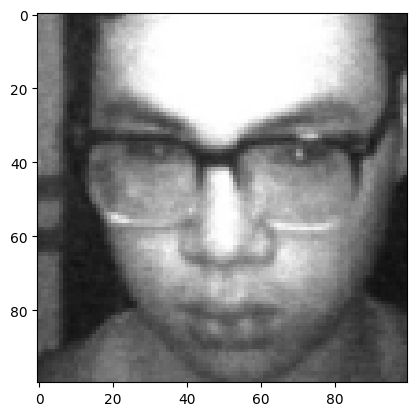

Validation image: 


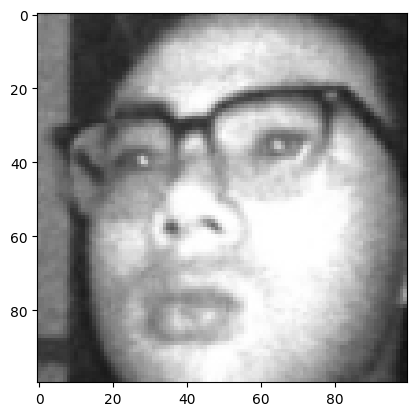

Label: 1.0


In [30]:
print("Anchor image: ")
plt.imshow(res[0])
plt.show()

print("Validation image: ")
plt.imshow(res[1])
plt.show()

# Directly print the value of res[2]
print("Label:", res[2])

After tesing all good for a single sample, we apply this process to all samples in the dataset.

In [31]:
data = data.map(preprocess_twin)
data = data.cache() # Cache the dataset to memory to get a speedup while reading from it

Currently, the dataset contains **positive classes consecutively, then negative classes consecutively**. We need to shuffle the dataset to make it more random.

In [32]:
# Before mix
for element in data.take(10):
    print(element[2].numpy())  # Print the label to see the mix of classes
# See if the appearance of 0 and 1 is random yet

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


2024-10-22 21:56:15.461978: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-22 21:56:15.463876: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
# Shuffle the dataset so that we have a good mix of positive and negative examples
data = data.shuffle(buffer_size=1024) 

In [34]:
# Check the dataset again to see that the two classes are mixed well
for element in data.take(10):
    print(element[2].numpy())  # Print the label to see the mix of classes
# See if the appearance of 0 and 1 is random yet

1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0


Now we split the Dataset in to Training and Testing set. We will use **70% for training and 30% for testing**.

In [35]:
train_data = data.take(round(len(data)*0.7)) # 70% of the data for training
train_data = train_data.batch(16) # Batch size of 16; batch size" refers to the number of training examples utilized in one iteration of the training process.
train_data = train_data.prefetch(8) # start processing the next batch while the current batch is being processed

In [36]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))

Size of original dataset: 100
Size of training dataset: 5


2024-10-22 21:56:15.711259: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
# Note that now each sample in train_data is 16 images
for element in train_data.take(1):
    print(f"Size of each sample in train_data: {element[0].shape}, {element[1].shape}, {element[2].shape}")

Size of each sample in train_data: (16, 100, 100, 3), (16, 100, 100, 3), (16,)


(16, 100, 100, 3) represents the anchor images in one single sample:

- 16: meaning there are 16 images in this batch.
- 100, 100: the height and width of each image, indicating that each image is 100 pixels by 100 pixels.
- 3: the number of color channels in each image. We store the image as Gray scale, but the vluae is duplicated 3 times to match the RGB format.

Similiarly for the remaining two elements in the tuple.

Shape of element[0][0]: (100, 100, 3)
Values of element[0][0]:
[[[0.4752451  0.4752451  0.4752451 ]
  [0.48921567 0.48921567 0.48921567]
  [0.45196077 0.45196077 0.45196077]
  ...
  [0.1257353  0.1257353  0.1257353 ]
  [0.1257353  0.1257353  0.1257353 ]
  [0.13333334 0.13333334 0.13333334]]

 [[0.4882353  0.4882353  0.4882353 ]
  [0.4968137  0.4968137  0.4968137 ]
  [0.43823528 0.43823528 0.43823528]
  ...
  [0.11960784 0.11960784 0.11960784]
  [0.12867647 0.12867647 0.12867647]
  [0.12156863 0.12156863 0.12156863]]

 [[0.4862745  0.4862745  0.4862745 ]
  [0.5125     0.5125     0.5125    ]
  [0.46519607 0.46519607 0.46519607]
  ...
  [0.12916666 0.12916666 0.12916666]
  [0.15465686 0.15465686 0.15465686]
  [0.13063726 0.13063726 0.13063726]]

 ...

 [[0.41740197 0.41740197 0.41740197]
  [0.36568627 0.36568627 0.36568627]
  [0.25343138 0.25343138 0.25343138]
  ...
  [0.09877451 0.09877451 0.09877451]
  [0.08970588 0.08970588 0.08970588]
  [0.07941177 0.07941177 0.07941177]]

 [[0.387254

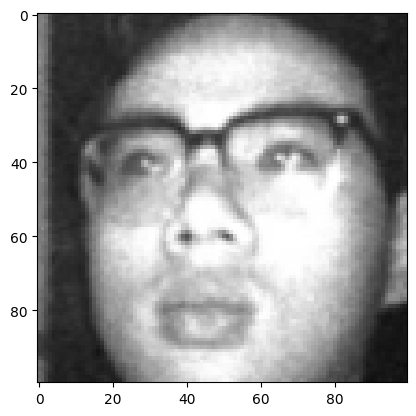

In [38]:
# Print the shape and values of element[0][0] (the first image in the first batch) to verify if it is stored as a grayscale image
print("Shape of element[0][0]:", element[0][0].shape)
print("Values of element[0][0]:")
print(element[0][0].numpy())

plt.imshow(element[0][0]) # Display the first image in the batch

In [39]:
# Do similar for the test data 30%
test_data = data.skip(round(len(data)*0.7)) # Skip the first 70% of the data which is used for training
test_data = test_data.take(round(len(data)*0.3)) 
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [40]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))
print("Size of test dataset:", len(list(test_data.as_numpy_iterator())))

Size of original dataset: 100
Size of training dataset: 5
Size of test dataset: 2


# Lec 4

## Objective

- Build an embedding layer / Encode Layer
- Create an L1 Distance layer
- Complie the Siamase Network

## 4.1 Build an Embedding Layer

Recall th idea, we have two stream of information (we  pass in two images: the anchor and the positive/negative image) -> Each stream will pass through an embedding layer to get the feature vector of the image -> Tow feature vectors will be used to calculate the distance between the two images at the Distance layer (here we use L1 distance).


Here is the Siamese Network architecture we are going to build:

![SiameseStructure](resources/images/SiameseStructure.png)

In the paper, it use input size of 105x105, but we will use 100x100 still okey. Therefore, **some numbers may not match exactly to the paper**

In [41]:
def make_embedding() :

    #Create the input layer
    inp = Input(shape=(100, 100, 3), name='input_image') # 100x100 image size, 3 channels color

   
    ### First Block ###
    # Next layer is a convolutional layer 64 filters, kernel size of 10x10, and ReLU activation
    c1= Conv2D(64, (10,10), activation='relu')(inp) # c1 stands for convolutional layer 1

    # Next layer is a max pooling layer with a pool size of 2x2
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) 



    ### Second Block ###
    # Next layer is a convolutional layer 128 filters, kernel size of 7x7, and ReLU activation
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    # Next layer is a max pooling layer with a pool size of 2x2
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)



    ### Third Block ###
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    ### Fourth Block ###
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) # Flatten the output of the convolutional layer to feed it to the dense layer
    d1 = Dense(4096, activation='sigmoid')(f1) # Dense layer with 4096 neurons and sigmoid activation

    
    return Model(inputs=[inp], outputs=[d1], name='Siamese__embedding_model')

As show in the above image, the output of the Embedding layer is a 4096-dimensional feature vector. Two streams of information will pass through this Embedding layer then we get two 4096-dimensional feature vectors for each image. **Basicaly, we are converting the face image to a 4096-dimensional feature vector.**

In [42]:
# Summary of the model
siamese_embedding_model = make_embedding()
siamese_embedding_model.summary()

Model: "Siamese__embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

How to read from the summary table:

This is a 4-dimensional tensor shape where each dimension represents, for example (None,100,100,3):

- None: This represents the batch size dimension. It's set to "None" because it's flexible - you can feed any number of images through the network at once.
- 100: The height of your input images (100 pixels)
- 100: The width of your input images (100 pixels)
- 3: The number of color channels

So in plain terms, your model is expecting input images that are:

- 100x100 pixels in size
- Color in 3 channels, can be RGB, BRG or even just grayscale but duplicated 3 times to match the format.
- Can be processed in batches of any size (that's what the None indicates)

## 4.2 Create an L1 Distance Layer

Compare two feature vectors to see how similiar our two images are

In [43]:

class L1Dist(Layer):
    def __init__(self, **kwargs):
         super(L1Dist, self).__init__(**kwargs)
    
    def call(self,input_embedding, validation_embedding):
        
        # Convert inputs to tensors otherwise will meet error: unsupported operand type(s) for -: 'List' and 'List'
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)

        # Calculate and return the L1 distance
        return tf.math.abs(input_embedding - validation_embedding)
    

## 4.3 Create final Siamese Network

We combine two above steps to make a fully Siamese model

In [44]:
def make_siamese_model():

    embedding_model = make_embedding()

    # Handle input images
    input_image = Input(shape=(100, 100, 3), name='input_image') # Anchor image
    validation_image = Input(shape=(100, 100, 3), name='validation_image') # Positive or negative image


    # Generate embeddings for the input images
    
    input_embedding = embedding_model(input_image)
    validation_embdedding = embedding_model(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embdedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Fully_Siamese_Network')


In [45]:
# Create the model
fully_siamese_model = make_siamese_model()
fully_siamese_model.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Look at the summary table, we see that the input of the model is two images size 100,100,3. (How many images per batch is not specified, so it's flexible). The output is a **single value**, which is the distance between the two images.

# 5. Train the Siamese Network

## Objective

- Set up a loss function, set up an optimizer
- Establish checkpoints
- Build a Custom Training Step
- Create a Training Loop
- Train the model

## 5.1 Set up a loss function and an optimizer

In [46]:
#Define the loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# from_logits=True is recommened when thr inputs to the loss function are not normalized 

In [47]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

There are tons of optimizer for Keras: SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Ftrl. We will use Adam optimizer.

## 5.2 Establish checkpoints

This checkpoint will save the model after each epoch. In case the training process is interrupted, we can resume the training from the last checkpoint.

In [48]:
# Create training_checkpoints directory in th machine
os.makedirs('./training_checkpoints', exist_ok=True)


checkpoint_dir = './training_checkpoints' # Directory to save the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #Prefix for the checkpoint files with unique number
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=fully_siamese_model)

# To reload the model from the checkpoint, use model.load('path_to_checkpoint'). This will
# load pre trainweights and optimizer state into existing model

## 5.3 Build a Custom Training Step

In this step, we defined actual trainning steps. We train on one batch of data, one batch of data come through our training step, we go on makeing prediction -> calcualte our loss function -> calculate gradient then apply back popagation (calculate new weights and apply) through our neutral network to get the best possible model

In [49]:
@tf.function # Annotation to indicate that complies to TensorFlow graph execution 
def train_step(batch):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation
        
        # Get the input images, validation images and labels from a batch
        input_images, validation_images, labels = batch

        
        # Forward pass
        predictions = fully_siamese_model([input_images, validation_images], training=True)
        # Set training=True for is important since some layers will only activated when this is set to True
    
    
        # Calculate the loss
        loss = binary_cross_loss(labels, predictions) # Measure the difference between the predicted value and the actual value
        print("Loss Vaule: ", loss)
    
        # Calculate the gradients
        gradients = tape.gradient(loss, fully_siamese_model.trainable_variables)

        # Update the weights and apply to the Siamese model
        optimizer.apply_gradients(zip(gradients, fully_siamese_model.trainable_variables))
        # Adam is a variant of stochastic gradient descent, it applies te learning rate and gradient to slightly reduce the loss function, unitll
        # it realy near the minimum value.



Recall the batch we created before:


In [50]:
# take one testing batch from train_data
test_batch = train_data.as_numpy_iterator()
test_batch = test_batch.next()
print("The length of the batch is", len(test_batch))
print("The first element of the batch is 16 anchor images: ", test_batch[0].shape)
print("The second element of the batch is 16 validation images: ", test_batch[1].shape)
print("The third element of the batch is a single label 1 or 0 (but write duplicated 16 times): ", test_batch[2].shape)

The length of the batch is 3
The first element of the batch is 16 anchor images:  (16, 100, 100, 3)
The second element of the batch is 16 validation images:  (16, 100, 100, 3)
The third element of the batch is a single label 1 or 0 (but write duplicated 16 times):  (16,)


## 5.4 Build Training Loop

In [51]:
def train(data, EPOCHS): # EPOCHS is the number of times the model will see the entire dataset

    # Loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS)) # Print the current epoch to know the progress of runnig
        progressBar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run the training step here
            train_step(batch)
            progressBar.update(idx+1) # Update the progress bar

    # Save our checkpoint 
    if (epoch) % 10 == 0: # Save the model every 10 epochs
        checkpoint.save(file_prefix = checkpoint_prefix)

## 5.5 Train the model

In [52]:
# Define the number of epochs
EPOCHS = 1

train(train_data, EPOCHS)


 Epoch 1/1


/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image']. Received: the structure of inputs=*
  warnings.warn(
/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
4/5 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepLoss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


2024-10-22 21:56:39.833038: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
# Load the model from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Lec 6

## Objective

- Evaluate the model
- Save the model for deployment


## 6.1 Envaluate the model

In this project, we will focus on enveluating **precision** and **recall**.

- Precision: The proportion of positive identifications that were actually correct.

- Recall: The proportion of actual positives that were identified correctly.

In [58]:
# Import metrics to evaluate the model
from tensorflow.keras.metrics import  Precision, Recall